In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
%run dataloader.ipynb

In [3]:
batch_size=500
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

In [5]:
gpu_id = 'cuda:1'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [5]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 81 ==> 8
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(81, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 32)
        )
          
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # 8 ==> 81
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 81),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

step error


/tmp/ipykernel_2093033/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2093033/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2093033/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

1 0.04964252561330795
2 0.02786126174032688
3 0.023423954844474792
4 0.02129523828625679
5 0.017899321392178535
6 0.015334535390138626
7 0.013559437356889248
8 0.01310691051185131
9 0.014500143006443977
10 0.012951018288731575
11 0.011947487480938435
12 0.013090623542666435
13 0.012150808237493038
14 0.012081514112651348
15 0.0122918039560318
16 0.01198199950158596
17 0.012114358134567738
18 0.011589252389967442
19 0.0107578095048666
20 0.011263806372880936
21 0.010502317920327187
22 0.011069527827203274
23 0.010378207080066204
24 0.00938884075731039
25 0.010464576072990894
26 0.009104632772505283
27 0.008910419419407845
28 0.008526005782186985
29 0.008994536474347115
30 0.008137205615639687
31 0.007479557767510414
32 0.007106035947799683
33 0.007603404112160206
34 0.007432801648974419
35 0.007160036358982325
36 0.007108702789992094
37 0.00673686433583498
38 0.007435251027345657
39 0.0063443537801504135
40 0.006681784987449646
41 0.006714762654155493
42 0.005483944434672594
43 0.006450

ValueError: x and y must have same first dimension, but have shapes (0,) and (100,)

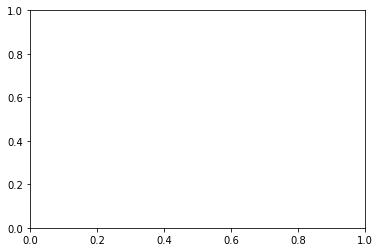

In [17]:
# input features
###
#idxs = torch.arange(300) # text, 300
idxs = torch.arange(300, 381) # speech, 81
#idxs = torch.arange(381, 752) # visual, 371
#idxs = torch.arange(381) # text + speech, 381
#idxs = torch.cat((torch.arange(300), torch.arange(381, 752))) # text + visual, 671
#idxs = torch.arange(300, 752) # speech + visual, 452
#idxs = torch.arange(752) # text + speech + visual, 752

device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
ae = AE()
ae.to(device)

optimiser = torch.optim.Adam(ae.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 100
patience = 20

print('step', 'error')
errors = []
best_error = np.inf
num_bad_epochs = 0
num_epochs = 0
best_epoch = 0
for epoch in range(1, epochs+1):
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        speech_batch = []
        for i, sent in enumerate(x_p):
            for j, word in enumerate(sent):
                if j < x_p_len[i]:
                    speech_batch.append(word[torch.arange(300, 381)].detach().tolist())
        speech_batch = torch.tensor(speech_batch, dtype=torch.float32, device=device)
        optimiser.zero_grad()
        _, output = ae(speech_batch)
        error = torch.nn.functional.mse_loss(output, speech_batch)
        error.backward()
        optimiser.step()

    error = error.detach().tolist()
    print(epoch, error)
    errors.append(error)

    if error < best_error:
        num_bad_epochs = 0
        best_error = error
        best_epoch = epoch
        torch.save(ae, 'autoencoder_speech.pth')
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            num_epochs = epoch
            break

plt.plot(range(1, num_epochs+1), errors, 'r')
plt.title('train error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

print('best model after {} epochs with error {}'.format(best_epoch, best_error))
ae = torch.load('autoencoder_speech.pth')

In [6]:
ae = torch.load('autoencoder_speech.pth')

In [19]:
for batch_idx, batch in enumerate(train_dataloader, 0):
    x_p,x_c,y,hid,x_p_len=map(lambda x: x.to('cuda:1'), batch)
    speech_batch = []
    for i, sent in enumerate(x_p):
        for j, word in enumerate(sent):
            if j < x_p_len[i]:
                speech_batch.append(word[torch.arange(381, 752)].detach().tolist())
    speech_batch = torch.tensor(speech_batch, dtype=torch.float32, device='cuda:1')
    print(speech_batch[0])
    #print(ae(speech_batch[0])[1])
    if batch_idx == 0:
        break

/tmp/ipykernel_2158469/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2158469/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2158469/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

tensor([1.0000e+00, 1.0000e+00, 5.6451e-01, 6.2728e-01, 2.0565e-02, 4.7851e-01,
        6.2589e-01, 1.9001e-02, 5.0860e-01, 5.4266e-01, 4.9736e-01, 4.9058e-01,
        4.8361e-01, 4.7963e-01, 4.8082e-01, 4.8842e-01, 4.9828e-01, 5.0074e-01,
        5.7610e-01, 5.5998e-01, 5.3670e-01, 5.1315e-01, 4.8905e-01, 4.8725e-01,
        4.8440e-01, 4.9080e-01, 5.0801e-01, 5.2765e-01, 5.4929e-01, 5.6546e-01,
        4.9206e-01, 4.9124e-01, 4.8828e-01, 4.8502e-01, 4.8349e-01, 4.8450e-01,
        4.8729e-01, 4.9041e-01, 2.2663e-01, 2.2904e-01, 2.2806e-01, 1.9800e-01,
        1.7907e-01, 1.7838e-01, 1.9781e-01, 2.1652e-01, 2.4042e-01, 2.1978e-01,
        1.9394e-01, 1.7205e-01, 1.5576e-01, 1.5095e-01, 1.4584e-01, 1.4591e-01,
        1.5359e-01, 1.6855e-01, 1.9176e-01, 2.1929e-01, 2.2006e-01, 2.0532e-01,
        1.9617e-01, 1.9649e-01, 2.0570e-01, 2.1988e-01, 2.2911e-01, 2.2787e-01,
        5.7278e-01, 5.8348e-01, 6.0078e-01, 6.1620e-01, 6.0813e-01, 5.9985e-01,
        5.8537e-01, 5.7310e-01, 5.5589e-